# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups),  and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e. it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 1, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.869216,0.850053
Balanced Accuracy,0.798157,0.771135
F1 score,0.707777,0.664222
MCC,0.626553,0.570764
Precision,0.760519,0.715527
Recall,0.661875,0.619781
ROC AUC,0.924979,0.823493


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.184776,0.012209
Predictive Parity,0.026482,0.361742
Equal Opportunity,0.105424,0.277381
Average Group Difference in False Negative Rate,0.105424,0.277381
Equalized Odds,0.085895,0.172345
Conditional Use Accuracy,0.054731,0.252315
Average Group Difference in Accuracy,0.092537,0.042491
Treatment Equality,0.173371,6.408608


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.869216           0.798157  0.707777  0.626553   
         0                   0.931077           0.773720  0.644586  0.613083   
         1                   0.838540           0.793249  0.718376  0.607907   
         Maximum difference  0.092537           0.019529  0.073790  0.005176   
updated  Overall             0.850053           0.771135  0.664222  0.570764   
         0                   0.878458           0.868256  0.605769  0.575215   
         1                   0.835967           0.763221  0.681570  0.593054   
         Maximum difference  0.042491           0.105036  0.075800  0.017840   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.760519  0.661875  0.924979          2922.0   
         0                    0.737609  0.572398  0.937296           442.0   
         1                    0.764091  0.677823  0.908942          2480.0   
         Maximum difference   0.026482  0.105424  0.028353          2038.0   
updated  Overall              0.715527  0.619781  0.823493          2922.0   
         0                    0.468983  0.855204  0.937296           442.0   
         1                    0.830725  0.577823  0.908942          2480.0   
         Maximum difference   0.361742  0.277381  0.028353          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.208255  
         0                                   0.084733  
         1                                   0.269509  
         Maximum difference                  0.184776  
updated  Overall                             0.207272  
         0                                   0.199111  
         1                                   0.211319  
         Maximum difference                  0.012209

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.083371,0.032152
Predictive Parity,0.085635,0.200541
Equal Opportunity,0.072516,0.162139
Average Group Difference in False Negative Rate,0.072516,0.162139
Equalized Odds,0.048156,0.100990
Conditional Use Accuracy,0.064761,0.136865
Average Group Difference in Accuracy,0.041193,0.034053
Treatment Equality,0.164911,2.722369


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.094247,0.019960
Predictive Parity,0.153589,0.236366
Equal Opportunity,0.107270,0.176566
Average Group Difference in False Negative Rate,0.107270,0.176566
Equalized Odds,0.074933,0.107233
Conditional Use Accuracy,0.098577,0.151591
Average Group Difference in Accuracy,0.057801,0.048646
Treatment Equality,0.244242,2.761935


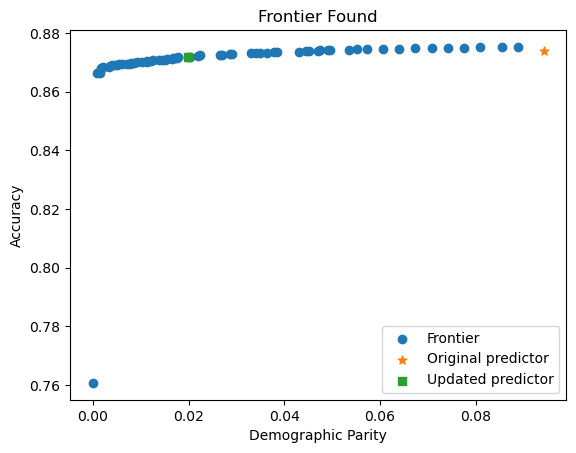

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

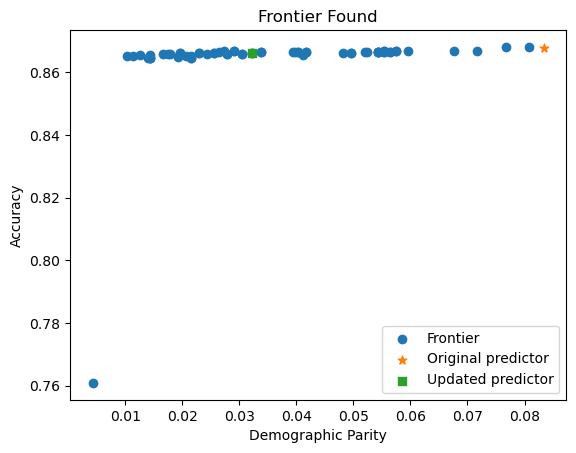

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.867742           0.792966  0.701534  0.620556   
         0                   0.910000           0.750255  0.571429  0.522016   
         1                   0.850746           0.795297  0.722222  0.626383   
         2                   0.929054           0.785701  0.658537  0.623067   
         3                   0.904762           0.750000  0.615385  0.571316   
         4                   0.860653           0.792002  0.703794  0.616652   
         Maximum difference  0.078308           0.045297  0.150794  0.104367   
updated  Overall             0.866186           0.795344  0.702259  0.618591   
         0                   0.880000           0.852911  0.600000  0.562947   
         1                   0.845771           0.757102  0.673684  0.610678   
         2                   0.913851           0.861025  0.677215  0.637722   
         3                   0.895238           0.883333  0.702703  0.659209   
         4                   0.861132           0.793447  0.705595  0.618422   
         Maximum difference  0.068080           0.126231  0.105595  0.096262   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.762555  0.649555  0.923851          2922.0   
         0                    0.600000  0.545455  0.928498            11.0   
         1                    0.795918  0.661017  0.908689           118.0   
         2                    0.729730  0.600000  0.953345           135.0   
         3                    0.727273  0.533333  0.940741            15.0   
         4                    0.763612  0.652667  0.920084          2643.0   
         Maximum difference   0.195918  0.127684  0.044656          2632.0   
updated  Overall              0.750974  0.659480  0.902493          2922.0   
         0                    0.473684  0.818182  0.928498            11.0   
         1                    0.888889  0.542373  0.908689           118.0   
         2                    0.591160  0.792593  0.953345           135.0   
         3                    0.590909  0.866667  0.940741            15.0   
         4                    0.763204  0.656073  0.920084          2643.0   
         Maximum difference   0.415205  0.324294  0.044656          2632.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                             89.0             0.110000   
         1                            284.0             0.293532   
         2                           1049.0             0.114020   
         3                             90.0             0.142857   
         4                           7777.0             0.253647   
         Maximum difference          7688.0             0.183532   
updated  Overall                     9289.0             0.239292   
         0                             89.0             0.110000   
         1                            284.0             0.293532   
         2                           1049.0             0.114020   
         3                             90.0             0.142857   
         4                           7777.0             0.253647   
         Maximum difference          7688.0             0.183532   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.203833  
         0                                   0.100000  
         1                                   0.243781  
         2                                   0.093750  
         3                                   0.104762  
         4        

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.873710           0.800645  0.714550  0.637681   
         0                   0.923729           0.703874  0.470588  0.430511   
         1                   0.824859           0.763548  0.651685  0.535024   
         2                   0.931639           0.800086  0.700000  0.668538   
         3                   0.937500           0.834106  0.750000  0.717825   
         4                   0.867917           0.800571  0.718261  0.636386   
         Maximum difference  0.112641           0.130232  0.279412  0.287314   
updated  Overall             0.871826           0.802691  0.714468  0.634613   
         0                   0.847458           0.764526  0.400000  0.367145   
         1                   0.847458           0.750010  0.649351  0.571308   
         2                   0.910605           0.864002  0.696429  0.652761   
         3                   0.937500           0.931418  0.800000  0.773394   
         4                   0.868108           0.801318  0.719124  0.637152   
         Maximum difference  0.090042           0.181408  0.400000  0.406250   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.778226  0.660507  0.926238          2922.0   
         0                    0.500000  0.444444  0.834862             9.0   
         1                    0.666667  0.637363  0.886934            91.0   
         2                    0.798246  0.623288  0.949508           146.0   
         3                    0.818182  0.692308  0.975904            13.0   
         4                    0.782301  0.663913  0.923741          2663.0   
         Maximum difference   0.318182  0.247863  0.141041          2654.0   
updated  Overall              0.765143  0.670089  0.907011          2922.0   
         0                    0.285714  0.666667  0.834862             9.0   
         1                    0.793651  0.549451  0.886934            91.0   
         2                    0.615789  0.801370  0.949508           146.0   
         3                    0.705882  0.923077  0.975904            13.0   
         4                    0.781746  0.665790  0.923741          2663.0   
         Maximum difference   0.507937  0.373626  0.141041          2654.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            109.0             0.076271   
         1                            263.0             0.257062   
         2                            995.0             0.127958   
         3                             83.0             0.135417   
         4                           7838.0             0.253595   
         Maximum difference          7755.0             0.180791   
updated  Overall                     9288.0             0.239312   
         0                            109.0             0.076271   
         1                            263.0             0.257062   
         2                            995.0             0.127958   
         3                             83.0             0.135417   
         4                           7838.0             0.253595   
         Maximum difference          7755.0             0.180791   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.203112  
         0                                   0.067797  
         1                                   0.245763  
         2                                   0.099912  
         3                                   0.114583  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.153916,0.028825,0.671429,0.666387
Disparate Impact,0.661823,0.935283,0.671429,0.654202
Average Group Difference in Conditional Acceptance Rate,0.237037,0.097929,0.671429,0.662185
Average Group Difference in Conditional Rejectance Rate,0.059308,0.020285,0.671429,0.673529
Average Group Difference in Accuracy,0.031330,0.031360,0.671429,0.667647
Average Group Difference in Recall,0.129283,0.032006,0.671429,0.668067
Average Group Difference in Acceptance Rate,0.047632,0.046458,0.671429,0.668908
Average Group Difference in Specificity,0.116876,0.046332,0.671429,0.670168
Average Group Difference in Rejection Rate,0.060134,0.056225,0.671429,0.668487
Treatment Equality,0.254167,0.089837,0.671429,0.671849


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.157456,0.098188,0.663866,0.625630
Disparate Impact,0.659160,0.754068,0.663866,0.621849
Average Group Difference in Conditional Acceptance Rate,0.251143,0.136377,0.663866,0.647479
Average Group Difference in Conditional Rejectance Rate,0.064538,0.069359,0.663866,0.657983
Average Group Difference in Accuracy,0.029461,0.032742,0.663866,0.660924
Average Group Difference in Recall,0.137655,0.126565,0.663866,0.633613
Average Group Difference in Acceptance Rate,0.049454,0.039150,0.663866,0.668067
Average Group Difference in Specificity,0.119530,0.107786,0.663866,0.654622
Average Group Difference in Rejection Rate,0.059023,0.051571,0.663866,0.660924
Treatment Equality,0.263356,0.229598,0.663866,0.654202


In [23]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.663866           0.654494  0.600000  0.315288   
         African-American    0.653815           0.654236  0.655229  0.308410   
         Caucasian           0.664198           0.626927  0.514286  0.271304   
         Other               0.698006           0.640643  0.509259  0.310690   
         Maximum difference  0.044191           0.027309  0.145969  0.039386   
updated  Overall             0.654202           0.644277  0.586224  0.295085   
         African-American    0.645611           0.646262  0.644152  0.292602   
         Caucasian           0.649383           0.610864  0.491039  0.237541   
         Other               0.695157           0.638410  0.506912  0.304637   
         Maximum difference  0.049546           0.035398  0.153112  0.067096   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.647249  0.559180  0.701835          1073.0   
         African-American     0.671692  0.639553  0.701341           627.0   
         Caucasian            0.597510  0.451411  0.675143           319.0   
         Other                0.617978  0.433071  0.687957           127.0   
         Maximum difference   0.074181  0.206483  0.026198           500.0   
updated  Overall              0.636463  0.543336  0.691370          1073.0   
         African-American     0.666099  0.623604  0.694328           627.0   
         Caucasian            0.573222  0.429467  0.658725           319.0   
         Other                0.611111  0.433071  0.680505           127.0   
         Maximum difference   0.092877  0.194137  0.035603           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.389496  
         African-American                    0.489746  
         Caucasian                           0.297531  
         Other                               0.253561  
         Maximum difference                  0.236184  
updated  Overall                             0.384874  
         African-American                    0.481542  
         Caucasian                           0.295062  
         Other                               0.256410  
         Maximum difference                  0.225132

In [24]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [25]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.740025,0.690676
Average Group Difference in Conditional Positive Prediction Rate,0.122323,0.019533


In [26]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.663866,0.621849
Average Group Difference in Conditional Positive Prediction Rate,0.159733,0.097350
